# **Deep Learning for Bird Species Classification:** **An Evaluation Using ResNet-18 on the CUB_200_2011 Dataset**
In this project, we focus on bird image classification, utilizing the CUB-200-2011 dataset for training. Our objective is to achieve domain specification and generalization by testing the trained model on a different dataset, Birds-525 Species. Both datasets share 67 common classes, which we used as a subset to ensure consistency in our results. To maintain uniformity, we aligned the class IDs and names in the test dataset with those in the training dataset. Initially, we employed a CNN architecture, and subsequently, we utilized transfer learning with a ResNet18 model, which yielded improved accuracy and performance metrics.

In [ ]:
import os
import random
import shutil
import warnings
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from tqdm import tqdm

warnings.filterwarnings("ignore")

import torchvision.models as models

# **Data Extraction and Annotation Processing for CUB-200-2011 Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
file_path = '/content/drive/My Drive/CUB_200_2011.tgz'


import tarfile
if file_path.endswith("tgz"):
    tar = tarfile.open(file_path, "r:gz")
    tar.extractall()
    tar.close()

extracted_folder_path = 'CUB_200_2011'
image_folder_path = os.path.join(extracted_folder_path, 'images')


import os
for root, dirs, files in os.walk(image_folder_path):
    for file in files:
        print(os.path.join(root, file))
    break


images_txt_path = os.path.join(extracted_folder_path, 'images.txt')
labels_txt_path = os.path.join(extracted_folder_path, 'image_class_labels.txt')
class_names_path = os.path.join(extracted_folder_path, 'classes.txt')

images_df = pd.read_csv(images_txt_path, sep=' ', header=None, names=['image_id', 'file_path'])
labels_df = pd.read_csv(labels_txt_path, sep=' ', header=None, names=['image_id', 'class_id'])
class_names_df = pd.read_csv(class_names_path, sep=' ', header=None, names=['class_id', 'class_name'])


data_df = pd.merge(images_df, labels_df, on='image_id')
data_df = pd.merge(data_df, class_names_df, on='class_id')

data_df['file_path'] = data_df['file_path'].apply(lambda x: os.path.join(image_folder_path, x))

print(data_df.shape)

(11788, 4)


In [ ]:
data_df

,image_id,file_path,class_id,class_name
0,1,CUB_200_2011/images/001.Black_footed_Albatross...,1,001.Black_footed_Albatross
1,2,CUB_200_2011/images/001.Black_footed_Albatross...,1,001.Black_footed_Albatross
2,3,CUB_200_2011/images/001.Black_footed_Albatross...,1,001.Black_footed_Albatross
3,4,CUB_200_2011/images/001.Black_footed_Albatross...,1,001.Black_footed_Albatross
4,5,CUB_200_2011/images/001.Black_footed_Albatross...,1,001.Black_footed_Albatross
...,...,...,...,...
11783,11784,CUB_200_2011/images/200.Common_Yellowthroat/Co...,200,200.Common_Yellowthroat
11784,11785,CUB_200_2011/images/200.Common_Yellowthroat/Co...,200,200.Common_Yellowthroat
11785,11786,CUB_200_2011/images/200.Common_Yellowthroat/Co...,200,200.Common_Yellowthroat
11786,11787,CUB_200_2011/images/200.Common_Yellowthroat/Co...,200,200.Common_Yellowthroat


# **Code to Filter and Copy Images to Desired Output Folder**
We aimed to ensure that the evaluation of our model is both accurate and meaningful. To achieve this, we decided to select a subset of common categories present in both the training and testing datasets.

In [ ]:

output_folder = 'filtered_images'

desired_categories = [7, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 28, 32, 35, 36, 42, 44,
                      45, 47, 48, 54, 55, 57, 59, 63, 67, 68, 72, 75, 76, 77, 78, 79, 85, 87,
                      89, 91, 93, 95, 99, 104,108, 109, 111, 114, 116, 118, 134, 136, 138,
                      139, 143, 149, 158, 163, 164,  186, 191, 192, 194]

train_data = data_df[data_df['class_id'].isin(desired_categories)]

for index, row in train_data.iterrows():
    class_name = row['class_name']
    src = row['file_path']
    dst = os.path.join(output_folder, class_name, os.path.basename(src))
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copy(src, dst)

for root, dirs, files in os.walk(output_folder):
    for file in files:
        print(os.path.join(root, file))
    break

# **Function to Clean Class Names and Reassign Class IDs**

### **Objective of Class ID Mapping:**
The primary goal of this mapping process is to ensure that class IDs are sequential and start from 0. This standardization simplifies data handling, improves compatibility with various machine learning frameworks, and ensures that the model's output aligns correctly with the expected class labels.

In [ ]:
import re
def clean_class_name(class_name):
    cleaned_name = re.sub(r'^\d+\.', '', class_name).strip()
    return cleaned_name

train_data['class_name'] = train_data['class_name'].apply(clean_class_name)

class_id_mapping = {original_id: new_id for new_id, original_id in enumerate(desired_categories)}

#print(class_id_mapping)

train_data['class_id'] = train_data['class_id'].map(class_id_mapping)
train_data = train_data.drop(columns=['image_id'])
train_data = train_data[['class_id', 'file_path', 'class_name']]
train_data.head()

,class_id,file_path,class_name
323,0,CUB_200_2011/images/007.Parakeet_Auklet/Parake...,Parakeet_Auklet
324,0,CUB_200_2011/images/007.Parakeet_Auklet/Parake...,Parakeet_Auklet
325,0,CUB_200_2011/images/007.Parakeet_Auklet/Parake...,Parakeet_Auklet
326,0,CUB_200_2011/images/007.Parakeet_Auklet/Parake...,Parakeet_Auklet
327,0,CUB_200_2011/images/007.Parakeet_Auklet/Parake...,Parakeet_Auklet


# **Analysis of Class Distribution in Training Data**

Class distribution:
class_id
0     53
1     59
2     60
3     56
4     60
      ..
58    60
59    60
60    60
61    60
62    60
Name: count, Length: 63, dtype: int64


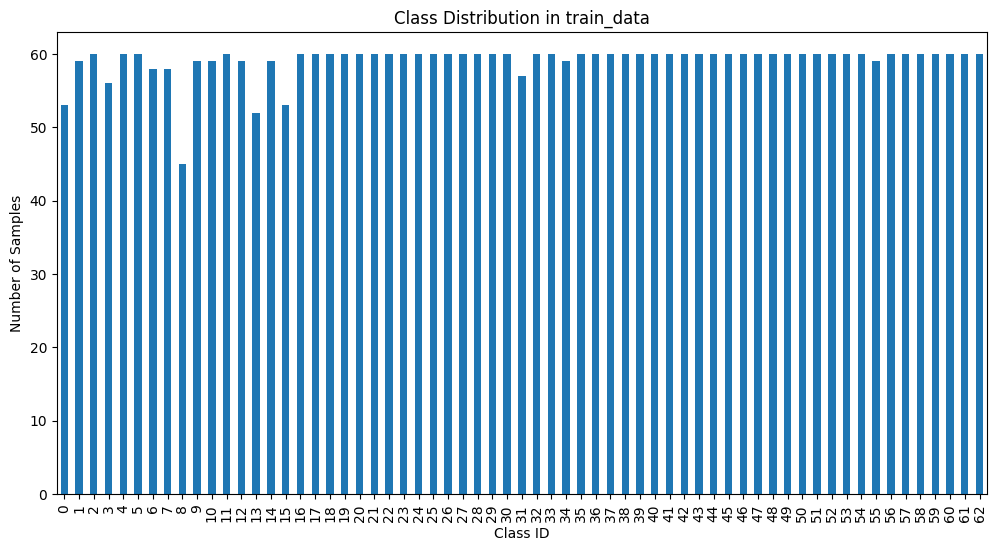

Minimum samples in a class: 45
Maximum samples in a class: 60
Mean number of samples per class: 59.13
Standard deviation of samples per class: 2.47
The classes are balanced.


In [ ]:
class_distribution = train_data['class_id'].value_counts().sort_index()
print("Class distribution:")
print(class_distribution)

plt.figure(figsize=(12, 6))
class_distribution.plot(kind='bar')
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in train_data')
plt.show()

min_samples = class_distribution.min()
max_samples = class_distribution.max()
mean_samples = class_distribution.mean()
std_samples = class_distribution.std()

print(f"Minimum samples in a class: {min_samples}")
print(f"Maximum samples in a class: {max_samples}")
print(f"Mean number of samples per class: {mean_samples:.2f}")
print(f"Standard deviation of samples per class: {std_samples:.2f}")

is_balanced = std_samples / mean_samples < threshold

if is_balanced:
    print("The classes are balanced.")
else:
    print("The classes are not balanced.")

The classes are not very much imbalance so we can proceed further.

In [ ]:
# # Create a mapping of class IDs to class names
# class_id_to_name = train_data[['class_id', 'class_name']].drop_duplicates().set_index('class_id').to_dict()['class_name']

# # Print the class IDs and their corresponding class names
# print("Class ID to Name Mapping:")
# for class_id, class_name in class_id_to_name.items():
#     print(f"Class ID: {class_id}, Class Name: {class_name}")

# **Visualization of Sample Images with Class Labels and IDs**

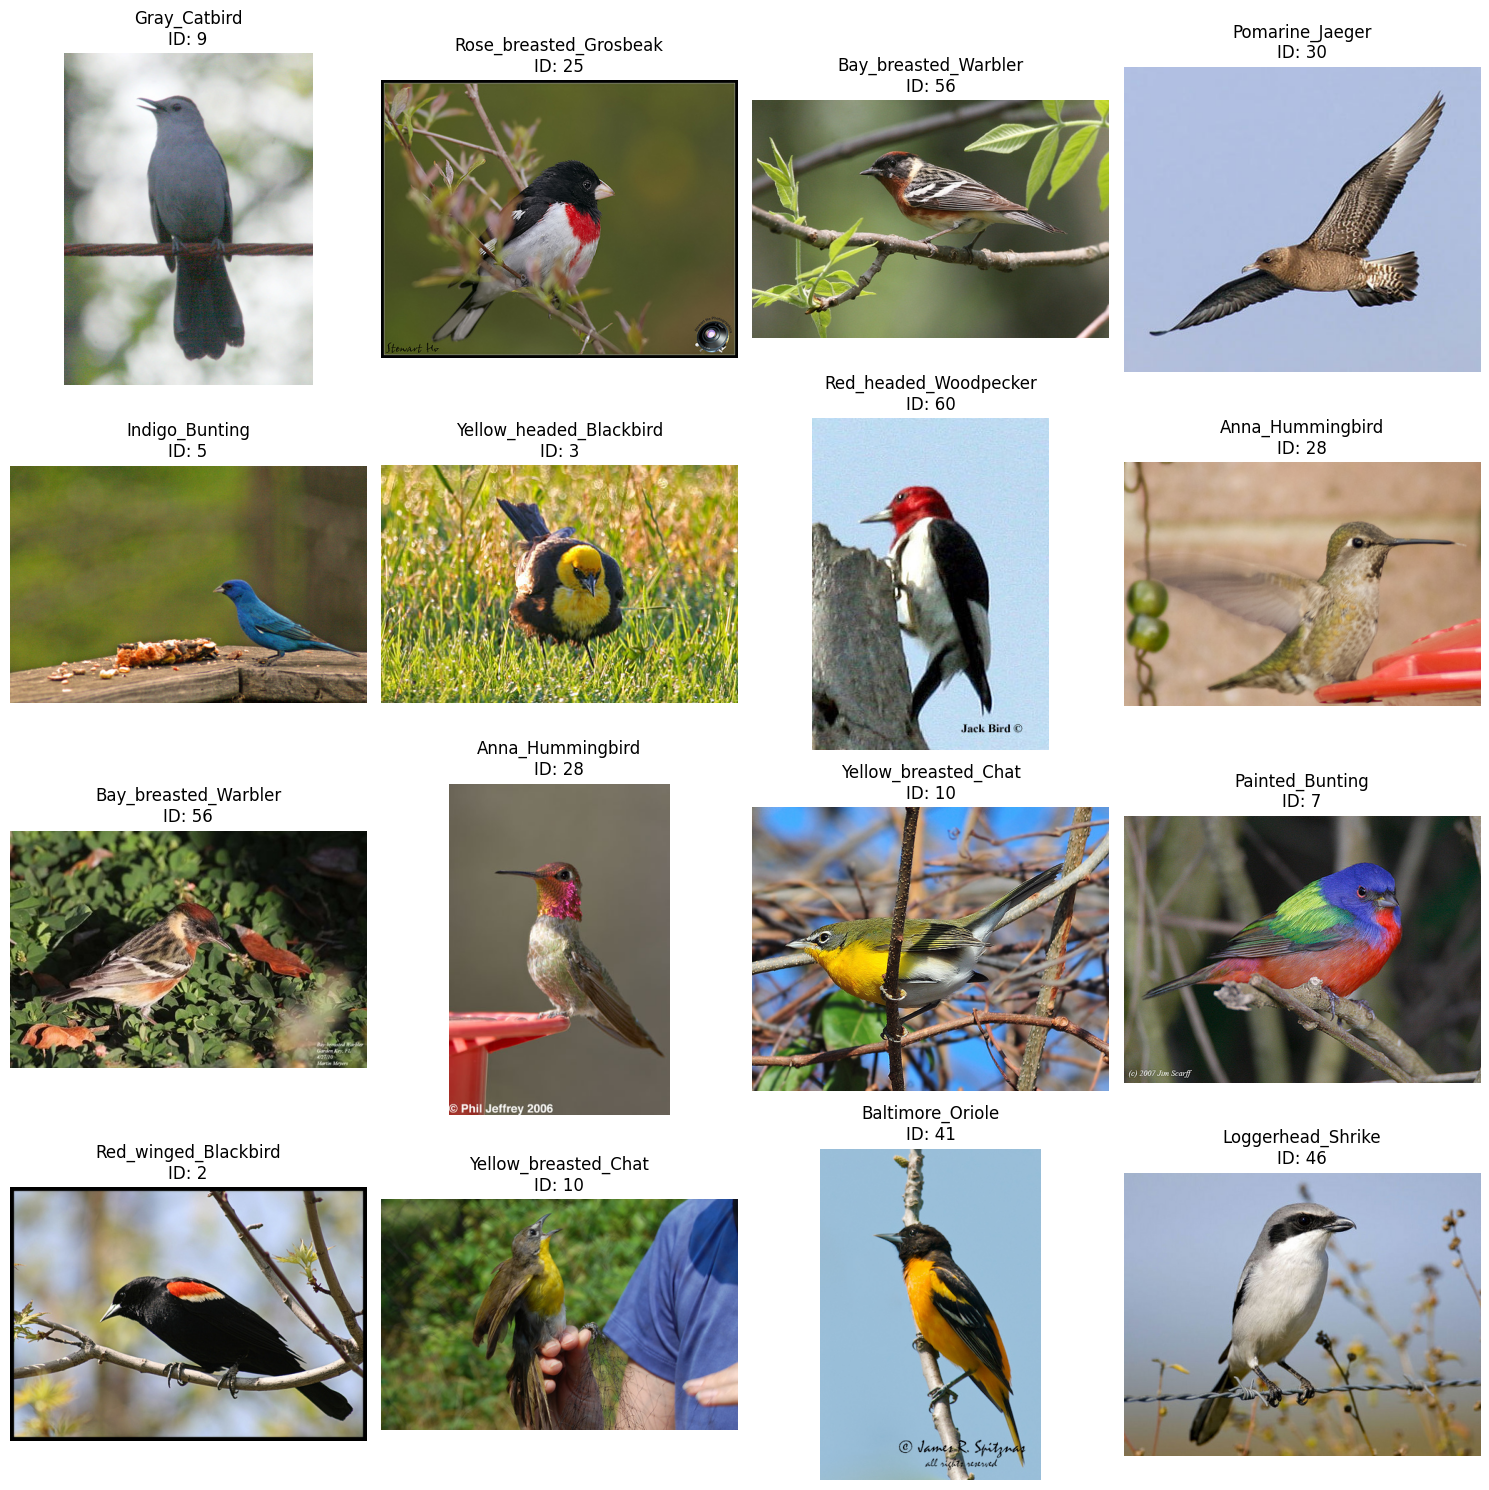

In [ ]:
def plot_images_with_labels(data_df, num_images=16):
    sample_data = data_df.sample(n=num_images)

    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    axes = axes.flatten()

    for ax, (idx, row) in zip(axes, sample_data.iterrows()):
        img = Image.open(row['file_path'])
        ax.imshow(img)
        ax.set_title(f"{row['class_name']}\nID: {row['class_id']}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_images_with_labels(train_data)

# **Data Augmentation and Normalization Transformations for Training and Validation Sets**

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# **Custom Dataset and DataLoader Setup for Multi-Class Classification**

In [ ]:
class MultiClassDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(img_path).convert("RGB")
        label = self.dataframe.iloc[idx]['class_id']
        if self.transform:
            image = self.transform(image)
        return image, label

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data_split, val_data_split = random_split(train_data, [train_size, val_size])

train_dataset = MultiClassDataset(train_data.iloc[train_data_split.indices], transform=transform_train)
val_dataset = MultiClassDataset(train_data.iloc[val_data_split.indices], transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# **Model Definition and Setup for Transfer Learning with ResNet-18**

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(desired_categories))
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)  # Adjust lr and momentum as needed
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


# **Training and Validation Loop with Early Stopping**

In [ ]:
def tabular_format(epochs, train_loss, train_acc, val_loss, val_acc):
    ep = list(range(1, epochs + 1))
    return pd.DataFrame({
        'Epoch': ep,
        'Training Loss': train_loss,
        'Training Accuracy': train_acc,
        'Validation Loss': val_loss,
        'Validation Accuracy': val_acc
    })

num_epochs = 50
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []
best_val_loss = float('inf')
patience = 5
count = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_train = 0
    correct_train = 0

    for itr, (image, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, label)
        total_train_loss += loss.item()

        predicted = torch.argmax(pred, dim=1)
        total_train += label.size(0)
        correct_train += (predicted == label).sum().item()

        loss.backward()
        optimizer.step()

    accuracy_train = (100 * correct_train) / total_train
    train_accuracy.append(accuracy_train)
    total_train_loss /= len(train_loader)
    train_loss.append(total_train_loss)

    model.eval()
    total_val_loss = 0
    total_val = 0
    correct_val = 0


    with torch.no_grad():
        for itr, (image, label) in enumerate(val_loader):
            image, label = image.to(device), label.to(device)  # Move data to GPU

            pred = model(image)
            loss = criterion(pred, label)
            total_val_loss += loss.item()

            predicted = torch.argmax(pred, dim=1)
            total_val += label.size(0)
            correct_val += (predicted == label).sum().item()

    accuracy_val = (100 * correct_val) / total_val
    val_accuracy.append(accuracy_val)
    total_val_loss /= len(val_loader)
    val_loss.append(total_val_loss)

    print(f'\nEpoch: {epoch + 1}/{num_epochs}, Train Loss: {total_train_loss:.4f}, '
          f'Train Accuracy: {accuracy_train:.2f}%, Val Loss: {total_val_loss:.4f}, '
          f'Val Accuracy: {accuracy_val:.2f}%')

    # Check for early stopping
    if total_val_loss < best_val_loss:
        count = 0
        best_val_loss = total_val_loss
        print(f"Saving the model state dictionary for Epoch: {epoch + 1} with Validation loss: {total_val_loss:.4f}")
        torch.save(model.state_dict(), "best_model.pth")
    else:
        count += 1

    if count == patience:
        print(f'Validation loss did not improve for {patience} consecutive epochs. Stopping training.')
        break

    scheduler.step()



print('Training complete.')

100%|██████████| 94/94 [00:38<00:00,  2.43it/s]



Epoch: 1/50, Train Loss: 3.7273, Train Accuracy: 13.09%, Val Loss: 2.2544, Val Accuracy: 40.67%
Saving the model state dictionary for Epoch: 1 with Validation loss: 2.2544


100%|██████████| 94/94 [00:42<00:00,  2.21it/s]



Epoch: 2/50, Train Loss: 2.7993, Train Accuracy: 27.95%, Val Loss: 1.7095, Val Accuracy: 54.77%
Saving the model state dictionary for Epoch: 2 with Validation loss: 1.7095


100%|██████████| 94/94 [00:33<00:00,  2.77it/s]



Epoch: 3/50, Train Loss: 2.3957, Train Accuracy: 37.95%, Val Loss: 1.4039, Val Accuracy: 55.97%
Saving the model state dictionary for Epoch: 3 with Validation loss: 1.4039


100%|██████████| 94/94 [00:33<00:00,  2.79it/s]



Epoch: 4/50, Train Loss: 2.2549, Train Accuracy: 42.05%, Val Loss: 1.5870, Val Accuracy: 57.05%


100%|██████████| 94/94 [00:33<00:00,  2.78it/s]



Epoch: 5/50, Train Loss: 2.0771, Train Accuracy: 45.64%, Val Loss: 1.3908, Val Accuracy: 61.88%
Saving the model state dictionary for Epoch: 5 with Validation loss: 1.3908


100%|██████████| 94/94 [00:37<00:00,  2.49it/s]



Epoch: 6/50, Train Loss: 1.5930, Train Accuracy: 56.78%, Val Loss: 0.6253, Val Accuracy: 82.68%
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.6253


100%|██████████| 94/94 [00:44<00:00,  2.10it/s]



Epoch: 7/50, Train Loss: 1.3968, Train Accuracy: 61.51%, Val Loss: 0.5542, Val Accuracy: 83.76%
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.5542


100%|██████████| 94/94 [00:38<00:00,  2.43it/s]



Epoch: 8/50, Train Loss: 1.3263, Train Accuracy: 63.79%, Val Loss: 0.5248, Val Accuracy: 86.58%
Saving the model state dictionary for Epoch: 8 with Validation loss: 0.5248


100%|██████████| 94/94 [00:38<00:00,  2.44it/s]



Epoch: 9/50, Train Loss: 1.2590, Train Accuracy: 65.44%, Val Loss: 0.4959, Val Accuracy: 86.71%
Saving the model state dictionary for Epoch: 9 with Validation loss: 0.4959


100%|██████████| 94/94 [00:36<00:00,  2.58it/s]



Epoch: 10/50, Train Loss: 1.1404, Train Accuracy: 68.56%, Val Loss: 0.4828, Val Accuracy: 86.58%
Saving the model state dictionary for Epoch: 10 with Validation loss: 0.4828


100%|██████████| 94/94 [00:35<00:00,  2.65it/s]



Epoch: 11/50, Train Loss: 1.2319, Train Accuracy: 67.15%, Val Loss: 0.4843, Val Accuracy: 86.31%


100%|██████████| 94/94 [00:39<00:00,  2.35it/s]



Epoch: 12/50, Train Loss: 1.2167, Train Accuracy: 65.87%, Val Loss: 0.4794, Val Accuracy: 86.58%
Saving the model state dictionary for Epoch: 12 with Validation loss: 0.4794


100%|██████████| 94/94 [00:34<00:00,  2.76it/s]



Epoch: 13/50, Train Loss: 1.0923, Train Accuracy: 69.53%, Val Loss: 0.4758, Val Accuracy: 87.11%
Saving the model state dictionary for Epoch: 13 with Validation loss: 0.4758


100%|██████████| 94/94 [00:34<00:00,  2.73it/s]



Epoch: 14/50, Train Loss: 1.1098, Train Accuracy: 69.40%, Val Loss: 0.4577, Val Accuracy: 87.65%
Saving the model state dictionary for Epoch: 14 with Validation loss: 0.4577


100%|██████████| 94/94 [00:33<00:00,  2.77it/s]



Epoch: 15/50, Train Loss: 1.1321, Train Accuracy: 69.06%, Val Loss: 0.4616, Val Accuracy: 87.38%


100%|██████████| 94/94 [00:36<00:00,  2.60it/s]



Epoch: 16/50, Train Loss: 1.1451, Train Accuracy: 68.89%, Val Loss: 0.4610, Val Accuracy: 87.79%


100%|██████████| 94/94 [00:36<00:00,  2.60it/s]



Epoch: 17/50, Train Loss: 1.1241, Train Accuracy: 68.72%, Val Loss: 0.4693, Val Accuracy: 87.65%


100%|██████████| 94/94 [00:33<00:00,  2.78it/s]



Epoch: 18/50, Train Loss: 1.1324, Train Accuracy: 68.89%, Val Loss: 0.4555, Val Accuracy: 87.79%
Saving the model state dictionary for Epoch: 18 with Validation loss: 0.4555


100%|██████████| 94/94 [00:34<00:00,  2.76it/s]



Epoch: 19/50, Train Loss: 1.1426, Train Accuracy: 67.92%, Val Loss: 0.4653, Val Accuracy: 87.38%


100%|██████████| 94/94 [00:33<00:00,  2.81it/s]



Epoch: 20/50, Train Loss: 1.1361, Train Accuracy: 68.02%, Val Loss: 0.4591, Val Accuracy: 87.92%


100%|██████████| 94/94 [00:33<00:00,  2.83it/s]



Epoch: 21/50, Train Loss: 1.1601, Train Accuracy: 68.42%, Val Loss: 0.4565, Val Accuracy: 87.79%


100%|██████████| 94/94 [00:36<00:00,  2.60it/s]



Epoch: 22/50, Train Loss: 1.1056, Train Accuracy: 69.80%, Val Loss: 0.4609, Val Accuracy: 87.92%


100%|██████████| 94/94 [00:33<00:00,  2.80it/s]



Epoch: 23/50, Train Loss: 1.1371, Train Accuracy: 69.46%, Val Loss: 0.4551, Val Accuracy: 88.46%
Saving the model state dictionary for Epoch: 23 with Validation loss: 0.4551


100%|██████████| 94/94 [00:33<00:00,  2.83it/s]



Epoch: 24/50, Train Loss: 1.1818, Train Accuracy: 67.55%, Val Loss: 0.4655, Val Accuracy: 88.05%


100%|██████████| 94/94 [00:33<00:00,  2.80it/s]



Epoch: 25/50, Train Loss: 1.1561, Train Accuracy: 68.76%, Val Loss: 0.4669, Val Accuracy: 86.71%


100%|██████████| 94/94 [00:33<00:00,  2.81it/s]



Epoch: 26/50, Train Loss: 1.1314, Train Accuracy: 68.52%, Val Loss: 0.4643, Val Accuracy: 87.52%


100%|██████████| 94/94 [00:36<00:00,  2.60it/s]



Epoch: 27/50, Train Loss: 1.1239, Train Accuracy: 68.66%, Val Loss: 0.4594, Val Accuracy: 87.79%


100%|██████████| 94/94 [00:33<00:00,  2.81it/s]



Epoch: 28/50, Train Loss: 1.1574, Train Accuracy: 68.86%, Val Loss: 0.4697, Val Accuracy: 87.65%
Validation loss did not improve for 5 consecutive epochs. Stopping training.
Training complete.


# **AFTER SOME MODIFICATIONS AND FINE TUNING OF HYPER-PARAMETERS:**

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class MultiClassDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(img_path).convert("RGB")
        label = self.dataframe.iloc[idx]['class_id']
        if self.transform:
            image = self.transform(image)
        return image, label

dataset = MultiClassDataset(dataframe=train_data, transform=transform_train)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(desired_categories))
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)  # Adjust lr and momentum as needed
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def TabularFormat(epochs, train_cost, train_acc, eval_cost, eval_acc):
    ep = list(range(1, epochs + 1))
    return pd.DataFrame(list(zip(ep, train_cost, train_acc, eval_cost, eval_acc)),
                        columns=['Epoch Value', 'Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])

num_epochs = 50
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []
best_val_loss = float('inf')
patience = 5
count = 0

# Training loop
for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0
    total_train = 0
    correct_train = 0
    model.train()

    # Training
    for itr, (image, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        image, label = image.to(device), label.to(device)  # Move data to GPU

        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, label)
        total_train_loss += loss.item()

        predicted = torch.argmax(pred, 1)
        total_train += label.size(0)
        correct_train += (predicted == label).sum().item()

        loss.backward()
        optimizer.step()

    accuracy_train = (100 * correct_train) / total_train
    train_accuracy.append(accuracy_train)
    total_train_loss /= len(train_loader)
    train_loss.append(total_train_loss)

    # Validation
    model.eval()
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for itr, (image, label) in enumerate(val_loader):
            image, label = image.to(device), label.to(device)  # Move data to GPU

            pred = model(image)
            loss = criterion(pred, label)
            total_val_loss += loss.item()

            predicted = torch.argmax(pred, dim=1)
            total_val += label.size(0)
            correct_val += (predicted == label).sum().item()

    accuracy_val = (100 * correct_val) / total_val
    val_accuracy.append(accuracy_val)
    total_val_loss /= len(val_loader)
    val_loss.append(total_val_loss)

    print(f'\nEpoch: {epoch + 1}/{num_epochs}, Train Loss: {total_train_loss:.8f}, '
          f'Train Accuracy: {accuracy_train:.8f}, Val Loss: {total_val_loss:.8f}, '
          f'Val Accuracy: {accuracy_val:.8f}')

    # Check for early stopping
    if total_val_loss < best_val_loss:
        count = 0
        best_val_loss = total_val_loss
        print(f"Saving the model state dictionary for Epoch: {epoch + 1} with Validation loss: {total_val_loss:.8f}")
        torch.save(model.state_dict(), "model.pth")
    else:
        count += 1

    if count == patience:
        print(f'Validation loss did not improve for {patience} consecutive epochs. Stopping training.')
        break

    scheduler.step()

100%|██████████| 94/94 [00:22<00:00,  4.16it/s]



Epoch: 1/50, Train Loss: 2.29826809, Train Accuracy: 40.30201342, Val Loss: 1.08283102, Val Accuracy: 68.05369128
Saving the model state dictionary for Epoch: 1 with Validation loss: 1.08283102


100%|██████████| 94/94 [00:22<00:00,  4.13it/s]



Epoch: 2/50, Train Loss: 0.79734020, Train Accuracy: 76.71140940, Val Loss: 1.56313926, Val Accuracy: 60.00000000


100%|██████████| 94/94 [00:24<00:00,  3.78it/s]



Epoch: 3/50, Train Loss: 0.49931112, Train Accuracy: 84.86577181, Val Loss: 0.98559029, Val Accuracy: 72.34899329
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.98559029


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]



Epoch: 4/50, Train Loss: 0.27452763, Train Accuracy: 92.14765101, Val Loss: 0.80126056, Val Accuracy: 78.79194631
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.80126056


100%|██████████| 94/94 [00:22<00:00,  4.16it/s]



Epoch: 5/50, Train Loss: 0.22931668, Train Accuracy: 93.08724832, Val Loss: 0.69307803, Val Accuracy: 80.80536913
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.69307803


100%|██████████| 94/94 [00:22<00:00,  4.20it/s]



Epoch: 6/50, Train Loss: 0.06890331, Train Accuracy: 98.62416107, Val Loss: 0.51649877, Val Accuracy: 86.57718121
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.51649877


100%|██████████| 94/94 [00:22<00:00,  4.19it/s]



Epoch: 7/50, Train Loss: 0.04446909, Train Accuracy: 99.02684564, Val Loss: 0.49808148, Val Accuracy: 86.71140940
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.49808148


100%|██████████| 94/94 [00:22<00:00,  4.25it/s]



Epoch: 8/50, Train Loss: 0.03615622, Train Accuracy: 99.63087248, Val Loss: 0.48756697, Val Accuracy: 86.84563758
Saving the model state dictionary for Epoch: 8 with Validation loss: 0.48756697


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]



Epoch: 9/50, Train Loss: 0.03368166, Train Accuracy: 99.53020134, Val Loss: 0.48341053, Val Accuracy: 87.38255034
Saving the model state dictionary for Epoch: 9 with Validation loss: 0.48341053


100%|██████████| 94/94 [00:21<00:00,  4.44it/s]



Epoch: 10/50, Train Loss: 0.02636057, Train Accuracy: 99.69798658, Val Loss: 0.48058217, Val Accuracy: 87.51677852
Saving the model state dictionary for Epoch: 10 with Validation loss: 0.48058217


100%|██████████| 94/94 [00:22<00:00,  4.20it/s]



Epoch: 11/50, Train Loss: 0.03317614, Train Accuracy: 99.73154362, Val Loss: 0.48400800, Val Accuracy: 86.30872483


100%|██████████| 94/94 [00:21<00:00,  4.45it/s]



Epoch: 12/50, Train Loss: 0.02449316, Train Accuracy: 99.69798658, Val Loss: 0.48122608, Val Accuracy: 87.65100671


100%|██████████| 94/94 [00:21<00:00,  4.46it/s]



Epoch: 13/50, Train Loss: 0.02700864, Train Accuracy: 99.69798658, Val Loss: 0.47790762, Val Accuracy: 87.51677852
Saving the model state dictionary for Epoch: 13 with Validation loss: 0.47790762


100%|██████████| 94/94 [00:21<00:00,  4.45it/s]



Epoch: 14/50, Train Loss: 0.02793132, Train Accuracy: 99.66442953, Val Loss: 0.47879502, Val Accuracy: 87.24832215


100%|██████████| 94/94 [00:21<00:00,  4.46it/s]



Epoch: 15/50, Train Loss: 0.02347413, Train Accuracy: 99.83221477, Val Loss: 0.46723664, Val Accuracy: 87.91946309
Saving the model state dictionary for Epoch: 15 with Validation loss: 0.46723664


100%|██████████| 94/94 [00:21<00:00,  4.41it/s]



Epoch: 16/50, Train Loss: 0.02852007, Train Accuracy: 99.73154362, Val Loss: 0.47574364, Val Accuracy: 87.91946309


100%|██████████| 94/94 [00:21<00:00,  4.42it/s]



Epoch: 17/50, Train Loss: 0.02582410, Train Accuracy: 99.66442953, Val Loss: 0.48293308, Val Accuracy: 87.38255034


100%|██████████| 94/94 [00:23<00:00,  4.06it/s]



Epoch: 18/50, Train Loss: 0.02096060, Train Accuracy: 99.79865772, Val Loss: 0.48051171, Val Accuracy: 87.24832215


100%|██████████| 94/94 [00:21<00:00,  4.28it/s]



Epoch: 19/50, Train Loss: 0.02921487, Train Accuracy: 99.66442953, Val Loss: 0.47413481, Val Accuracy: 87.38255034


100%|██████████| 94/94 [00:22<00:00,  4.26it/s]



Epoch: 20/50, Train Loss: 0.03060905, Train Accuracy: 99.93288591, Val Loss: 0.47501029, Val Accuracy: 87.78523490
Validation loss did not improve for 5 consecutive epochs. Stopping training.


In [ ]:
df_m2 = TabularFormat(num_epochs, train_loss, train_accuracy, val_loss, val_accuracy)
df_m2

,Epoch Value,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy
0,1,2.298268,40.302013,1.082831,68.053691
1,2,0.797340,76.711409,1.563139,60.000000
2,3,0.499311,84.865772,0.985590,72.348993
3,4,0.274528,92.147651,0.801261,78.791946
4,5,0.229317,93.087248,0.693078,80.805369
5,6,0.068903,98.624161,0.516499,86.577181
6,7,0.044469,99.026846,0.498081,86.711409
7,8,0.036156,99.630872,0.487567,86.845638
8,9,0.033682,99.530201,0.483411,87.382550
9,10,0.026361,99.697987,0.480582,87.516779


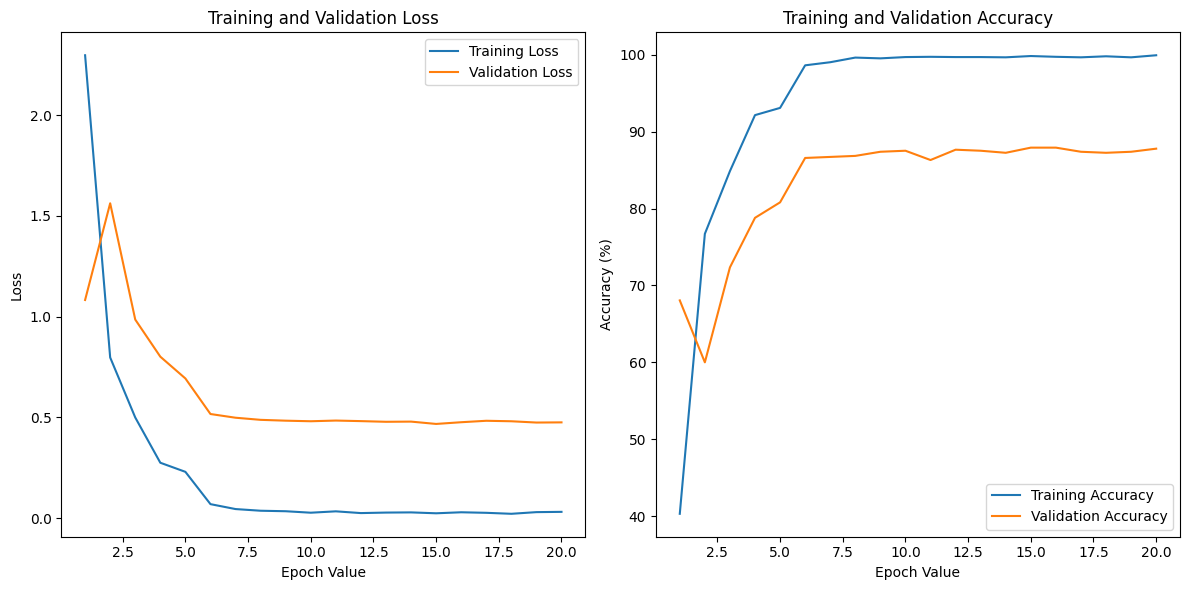

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_m2['Epoch Value'], df_m2['Training Loss'], label='Training Loss')
plt.plot(df_m2['Epoch Value'], df_m2['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch Value')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_m2['Epoch Value'], df_m2['Training Accuracy'], label='Training Accuracy')
plt.plot(df_m2['Epoch Value'], df_m2['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch Value')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **Summary:**
The model shows good learning and generalization capabilities, with training accuracy reaching near perfection and validation accuracy steadily improving to around 87.5%. The early stopping mechanism helps prevent overfitting, ensuring the model doesn't just memorize training data but learns patterns useful for unseen data. The final model can classify the validation set with a high degree of accuracy, indicating it has learned to generalize well from the training data.

# **Testing on the Birds_525 Species Dataset**
Following the completion of the training phase on the CUB-200-2011 dataset, we proceeded to evaluate the performance of our trained model on the Birds_525 species dataset. This dataset, which includes a diverse range of bird species, serves as an external benchmark to assess the generalizability and robustness of the model.

We leveraged the same preprocessing techniques and transformations as employed during training to ensure consistency in the data pipeline. The model's performance was evaluated based on metrics such as accuracy, precision, recall, and F1-score, providing a comprehensive assessment of its effectiveness across different bird species.